In [2]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as func
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.optim as optim

torch.cuda.empty_cache()
import seaborn as sns

import numpy as np
import PIL.Image
from matplotlib import pylab as P
import torch
from torchvision import models, transforms


import os
import cv2

In [5]:
train_df = pd.read_csv('C:/Users/david/Desktop/DSC 180A - FA22/DSC180A/data/out/traindata.csv')
valid_df = pd.read_csv('C:/Users/david/Desktop/DSC 180A - FA22/DSC180A/data/out/valdata.csv')

In [11]:
train_df.drop('Unnamed: 0',axis=1,inplace=True)
valid_df.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
%load_ext autoreload
%autoreload 2

In [3]:
#!del /Q /S /F runs\*
#!rmdir /S /Q runs

In [7]:
torch.cuda.is_available(), torch.version.cuda

(True, '11.7')

%load_ext tensorboard
torch.backends.cudnn.benchmark = True
writer=SummaryWriter()
%tensorboard --logdir='runs/' --inspect

!start chrome http://localhost:6006/

In [8]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

!pip install https://download.pytorch.org/whl/nightly/cu117/torch-1.14.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
!pip install https://download.pytorch.org/whl/nightly/cu117/torchvision-0.15.0.dev20221030%2Bcu117-cp39-cp39-linux_x86_64.whl
torch.cuda.is_available(), torch.version.cuda

In [24]:
train_df

,unique_key,bnpp_value_log,BNP_value,path,heart
0,Abachug_50267230_img1,2.621176,418.0,/home/ddavilag/private/data/bnpp_224_pandas/Ab...,1
1,Abafouck_52403307_img1,2.071882,118.0,/home/ddavilag/private/data/bnpp_224_pandas/Ab...,0
2,Abagash_52691625_img1,1.698101,49.9,/home/ddavilag/private/data/bnpp_224_pandas/Ab...,0
3,Abakleem_50725934_img1,4.301659,20029.0,/home/ddavilag/private/data/bnpp_224_pandas/Ab...,1
4,Abaphos_51936331_img1,3.219323,1657.0,/home/ddavilag/private/data/bnpp_224_pandas/Ab...,1
...,...,...,...,...,...
15159,Zolisjeg_52354860_img1,2.550228,355.0,/home/ddavilag/private/data/bnpp_224_pandas/Zo...,0
15160,Zufibo_50586634_img1,2.772322,592.0,/home/ddavilag/private/data/bnpp_224_pandas/Zu...,1
15161,Zufosloo_50189474_img1,3.475381,2988.0,/home/ddavilag/private/data/bnpp_224_pandas/Zu...,1
15162,Zunakot_51932665_img1,2.089905,123.0,/home/ddavilag/private/data/bnpp_224_pandas/Zu...,0


DATA_PATH = '/home/ddavilag/teams/dsc-180a---a14-[88137]/df_bnpp_datapaths.csv'
KEY_PATH = '/home/ddavilag/teams/dsc-180a---a14-[88137]/df_bnpp_keys.csv'

df_datapaths = pd.read_csv(DATA_PATH, header=None).T.merge(pd.read_csv(KEY_PATH, header=None).T, left_index=True, right_index=True)
df_datapaths.columns = ['filepaths', 'key']
df_datapaths.key = df_datapaths.key.apply(lambda x: eval(x))
df_datapaths.filepaths = df_datapaths.filepaths.apply(lambda x: eval(x))
df_datapaths = df_datapaths.set_index('key')
#missing h5py files 7-9

cols= ['unique_key', 'bnpp_value_log', 'BNP_value' 
        #'BNPP_weight', 'PNA_mask', 'PNA_wight_mask', 'BNP_value', 'age_at_sampletime'
       ]
test_df = pd.read_csv('/home/ddavilag/teams/dsc-180a---a14-[88137]/BNPP_DT_test_with_ages.csv', usecols = cols).set_index('unique_key')
train_df = pd.read_csv('/home/ddavilag/teams/dsc-180a---a14-[88137]/BNPP_DT_train_with_ages.csv', usecols = cols).set_index('unique_key')
val_df = pd.read_csv('/home/ddavilag/teams/dsc-180a---a14-[88137]/BNPP_DT_val_with_ages.csv', usecols = cols).set_index('unique_key')
print(train_df.shape, test_df.shape, val_df.shape)
train_df['heart'] = train_df['BNP_value'].apply(lambda x: int(x > 400))
test_df['heart'] = test_df['BNP_value'].apply(lambda x: int(x > 400))
val_df['heart'] = val_df['BNP_value'].apply(lambda x: int(x > 400))


train_df = train_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
test_df = test_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
val_df = val_df.sort_index().merge(df_datapaths, left_index=True, right_index=True)
print(train_df.shape, test_df.shape, val_df.shape)

train_df['filepaths'] = train_df['filepaths'].str.replace('jmryan','ddavilag')
test_df['filepaths'] = test_df['filepaths'].str.replace('jmryan','ddavilag')
val_df['filepaths'] = val_df['filepaths'].str.replace('jmryan','ddavilag')
new_valid = pd.concat([test_df,val_df],ignore_index=False)
train_df.shape, test_df.shape, val_df.shape,new_valid.shape

train_df.reset_index(names='unique_key',inplace=True)
val_df.reset_index(names='unique_key',inplace=True)
test_df.reset_index(names='unique_key',inplace=True)
new_valid.reset_index(names='unique_key',inplace=True)

train_df = train_df.to_numpy()
new_valid = new_valid.to_numpy()
val_df = val_df.to_numpy()
test_df = test_df.to_numpy()

In [16]:
#from zmq import device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class PreprocessedImageDataset(Dataset):
    def __init__(self, df, transform=None, target_transform=None):
        self.df = df
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row = self.df[idx,:]
        #plt.imshow(im,cmap='gray')
        #plt.show()
        #returns image, bnpp value log, binary variable for edema
        #print(row)
        #resnet
        return torch.load(row[4]).view(1, 224, 224).expand(3, -1, -1), row[1], row[3]
    
        #vgg?
        #return torch.load(row[4]).view(1, 224, 224), row[1], row[3]

In [23]:
batch_size = 16 #maybe change to 16, 8
num_workers = 0
pin_memory = True
# train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

train_set = PreprocessedImageDataset(df=train_df) #, transform = train_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# valid_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=(0.5), std=(0.5))
#     ])

valid_set = PreprocessedImageDataset(df=valid_df) #, transform = valid_transform)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

#print(train_set[0])
#print(iter(train_loader).next())
#print(train.__getitem__(0))
#len(valid_set)
# test_set = PreprocessedImageDataset(df=test_df)
# test_loader = DataLoader(test_set, batch_size=1, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)

import time
pin_memory = True
print('pin_memory is', pin_memory)
 
for num_workers in range(0, 5): 
    #train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    #sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
    start = time.time()
    for epoch in range(1, 3):
        for i, data in enumerate(train_loader):
            pass
    end = time.time()
    print("Finish with:{} second, num_workers={}".format(end - start, num_workers))

In [15]:
plt.imshow(valid_set[0][0].permute(1, 2, 0),cmap='gray')

InvalidIndexError: (0, slice(None, None, None))

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = 'ResNet'
if model == 'VGG16':
    model = VGG('VGG16').to(device)
elif model == 'ResNet':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', weights='DEFAULT')
    model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    model.to(device)
model

cuda


Using cache found in /home/ddavilag/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys_r")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels, _ = dataiter.next()

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)
print('  '.join(str('%.2f' % labels[j].item()) for j in range(batch_size)))

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

total_params = sum(p.numel() for p in model.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)

# the optimizer
# need to tune optimizer
LR = 0.0001
RHO = 0.99
#optimizer = optim.Adadelta(model.parameters(), lr=LR)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

[INFO]: Computation device: cuda
[INFO]: 58,145,857 total parameters.
[INFO]: 58,145,857 trainable parameters.


In [12]:
os.environ['NUM_GPU']='1'

In [13]:
epoch_number = 0

EPOCHS = 15
#best_vloss = 1_000_000.

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses, vlosses = np.array([]),np.array([])

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))


    for param in model.parameters():
        param.requires_grad = True
    avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    
    for param in model.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss, avg_vloss))

    tlosses = np.append(tlosses,avg_tloss)
    vlosses = np.append(vlosses,avg_vloss)
    print(tlosses)

    epoch_number += 1
    scheduler.step(avg_vloss)

EPOCH 1:


100%|██████████| 120/120 [00:12<00:00,  9.81it/s]

LOSS train 0.6010955525367792 valid 0.5495182671155544
[0.60109555]
EPOCH 2:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.4779323530837029 valid 0.5080274353628753
[0.60109555 0.47793235]
EPOCH 3:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.41977036619168395 valid 0.4839108437389949
[0.60109555 0.47793235 0.41977037]
EPOCH 4:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.3706574123389035 valid 0.5004022059394465
[0.60109555 0.47793235 0.41977037 0.37065741]
EPOCH 5:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.33393988916898965 valid 0.5226665732737757
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989]
EPOCH 6:



  1%|          | 8/948 [00:03<05:54,  2.65it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  1%|          | 9/948 [00:03<05:53,  2.66it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] W

LOSS train 0.3015255249822885 valid 0.5041552728527582
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989 0.30152552]
EPOCH 7:



  0%|          | 0/948 [00:00<?, ?it/s]/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: initialization error (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:46.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: invalid device ordinal (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:62.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (func

LOSS train 0.27605120116988185 valid 0.48319521496097406
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989 0.30152552
 0.2760512 ]
EPOCH 8:



  1%|▏         | 14/948 [00:05<05:44,  2.71it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  2%|▏         | 15/948 [00:05<05:42,  2.72it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.25945876478044855 valid 0.47357180323823334
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989 0.30152552
 0.2760512  0.25945876]
EPOCH 9:



  0%|          | 0/948 [00:00<?, ?it/s]/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: initialization error (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:46.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
/home/ddavilag/.local/lib/python3.9/site-packages/torch/_utils.py:147: UserWarning: CUDA warning: invalid device ordinal (Triggered internally at ../c10/cuda/impl/CUDAGuardImpl.h:62.)
  return t.set_(storage.untyped(), storage_offset, size, stride)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (func

LOSS train 0.24264105440520453 valid 0.47395737859894227
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989 0.30152552
 0.2760512  0.25945876 0.24264105]
EPOCH 10:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.22709542903579685 valid 0.4859437367630541
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989 0.30152552
 0.2760512  0.25945876 0.24264105 0.22709543]
EPOCH 11:



  9%|▉         | 86/948 [00:32<05:22,  2.67it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  9%|▉         | 87/948 [00:32<05:21,  2.68it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.21722613619690528 valid 0.48324399156317127
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989 0.30152552
 0.2760512  0.25945876 0.24264105 0.22709543 0.21722614]
EPOCH 12:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.2080405057405537 valid 0.4955831946963733
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989 0.30152552
 0.2760512  0.25945876 0.24264105 0.22709543 0.21722614 0.20804051]
EPOCH 13:



  5%|▍         | 46/948 [00:17<05:36,  2.68it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  5%|▍         | 47/948 [00:17<05:37,  2.67it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.20189702706313814 valid 0.46570893248312384
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989 0.30152552
 0.2760512  0.25945876 0.24264105 0.22709543 0.21722614 0.20804051
 0.20189703]
EPOCH 14:



  0%|          | 0/948 [00:00<?, ?it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function 

LOSS train 0.19335062922980115 valid 0.4706930636651819
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989 0.30152552
 0.2760512  0.25945876 0.24264105 0.22709543 0.21722614 0.20804051
 0.20189703 0.19335063]
EPOCH 15:



  4%|▎         | 34/948 [00:12<05:42,  2.67it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
  4%|▎         | 35/948 [00:13<05:40,  2.68it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62]

LOSS train 0.1852505672359965 valid 0.4634154762650479
[0.60109555 0.47793235 0.41977037 0.37065741 0.33393989 0.30152552
 0.2760512  0.25945876 0.24264105 0.22709543 0.21722614 0.20804051
 0.20189703 0.19335063 0.18525057]


In [14]:
#loss on unseen test set
for param in model.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, model, loss_fn, test_loader)
print(test_loss)

 48%|████▊     | 881/1823 [00:33<00:32, 29.11it/s][W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal (function uncheckedSetDevice)
[W CUDAGuardImpl.h:46] Warning: CUDA warning: initialization error (function uncheckedGetDevice)
[W CUDAGuardImpl.h:62] Warning: CUDA warning: invalid device ordinal 

0.46951640631668345


/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:676: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


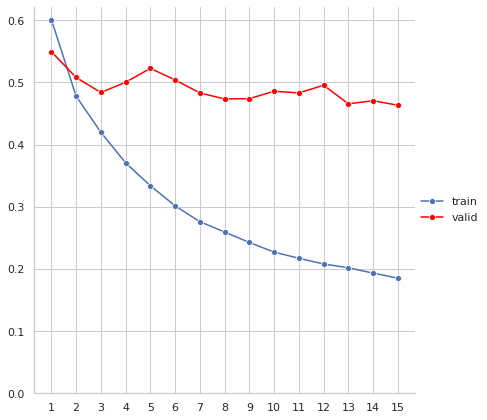

In [15]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses,'valid loss':vlosses})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='train')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='valid')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

### VGG SECTION

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model2 = 'VGG16'
if model2 == 'VGG16':
    model2 = VGG('VGG16').to(device)
elif model2 == 'ResNet':
    model2 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', weights='DEFAULT')
    model2.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
    model2.to(device)
model2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO]: Computation device: {device}")

total_params = sum(p.numel() for p in model2.parameters())
print(f"[INFO]: {total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model2.parameters() if p.requires_grad)
print(f"[INFO]: {total_trainable_params:,} trainable parameters.")

# the loss function, Mean Absolute Error
loss_fn = nn.L1Loss().to(device)
#loss_fn = nn.HuberLoss().to(device)
#loss_fn = nn.SmoothL1Loss().to(device)

# the optimizer
# need to tune optimizer
LR = 0.0001
RHO = 0.99
#optimizer = optim.Adadelta(model.parameters(), lr=LR)
optimizer = optim.Adam(model2.parameters(), lr=0.0001)

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
#timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
epoch_number = 0

EPOCHS = 15
#best_vloss = 1_000_000.

# the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

tlosses2, vlosses2 = np.array([]),np.array([])
# writer.add_text('model params', \
#                 f'''VGG16\n
#                 loss: {'MAE'}\n
#                 optimizer: {'Adam'}\n
#                 \tlearn rate: {LR}\n
#                 \trho: {RHO}\n
#                 batch size: {batch_size}\n
#                 nodes: {500}\n
#                 dropout: {0}\n
#                 batchnorm: {'yes'}\n
#                 RELU: {'Leaky'}\n
#                 epochs: {EPOCHS}
#                 ''',\
#                 0)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

#     for param in model.parameters():
#         param.requires_grad = True
    #avg_tloss = train1Epoch(epoch_number, model, optimizer, loss_fn, train_loader)#, writer)
    for param in model2.parameters():
        param.requires_grad = True
    avg_tloss2 = train1Epoch(epoch_number, model2, optimizer, loss_fn, train_loader)#, writer)
    
    
#     for param in model.parameters():
#         param.requires_grad = False
#     with torch.no_grad():
#         avg_vloss = test1Epoch(epoch_number, model, loss_fn, valid_loader)
    for param in model2.parameters():
        param.requires_grad = False
    with torch.no_grad():
        avg_vloss2 = test1Epoch(epoch_number, model2, loss_fn, valid_loader)

    print('LOSS train {} valid {}'.format(avg_tloss2, avg_vloss2))
    #writer.add_scalars('Loss', {'train':avg_tloss,'test':avg_vloss}, epoch)
    tlosses2 = np.append(tlosses2,avg_tloss2)
    vlosses2 = np.append(vlosses2,avg_vloss2)

    epoch_number += 1
    scheduler.step(avg_vloss2)
    #https://debuggercafe.com/using-learning-rate-scheduler-and-early-stopping-with-pytorch/
#writer.flush()
#writer.close()

In [ ]:
#loss on unseen test set
for param in model2.parameters():
    param.requires_grad = False
with torch.no_grad():
    test_loss = test1Epoch(epoch_number, model2, loss_fn, test_loader)
print(test_loss)

In [ ]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss': tlosses2,'valid loss':vlosses2})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses2,marker='o', label='train')
g = g.map(sns.lineplot, x=epochs,y=vlosses2,color='red',marker='o', label='valid')
g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

In [ ]:
epochs = np.arange(1,EPOCHS+1)
df = pd.DataFrame(data={'train loss resnet': tlosses,'valid loss resnet':vlosses, 'train loss vgg': tlosses2,'valid loss vgg':vlosses2})
sns.set(style='whitegrid')
g = sns.FacetGrid(df, height = 6)
g = g.map(sns.lineplot, x=epochs,y=tlosses,marker='o', label='resnet train')
g = g.map(sns.lineplot, x=epochs,y=vlosses,color='red',marker='o', label='resnet valid')
g = g.map(sns.lineplot, x=epochs,y=tlosses2,color='green',marker='o', label='vgg16 train')
g = g.map(sns.lineplot, x=epochs,y=vlosses2,color='orange',marker='o', label='vgg16 valid')

g.set(ylim=(0, None))
g.add_legend()
plt.xticks(epochs)
plt.show()

### Resnet AUC work

In [ ]:
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds, hearts = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = model(image)
            hearts = np.append(hearts, heart)
            #preds = np.append(preds, pred.item())
            preds = np.append(preds, pred.cpu())

In [ ]:
preds

In [ ]:
prob_preds = np.power(10,preds) / (np.power(10,preds)).sum()

In [ ]:
np.power(10,np.log10(400))/(np.power(10,preds)).sum()

In [ ]:
y_preds = prob_preds > (np.power(10,np.log10(400))/(np.power(10,preds)).sum())
y_preds.sum()

In [ ]:
hearts

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

print(f'accuracy score: {accuracy_score(hearts, y_preds)}')
tn, fp, fn, tp = confusion_matrix(hearts, y_preds).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts, y_preds)
print('Confusion matrix')
print(cf_mat)
print()
cf_mat_norm = confusion_matrix(hearts, y_preds,normalize='true')
print(cf_mat_norm)

### VGG16 AUC Work

In [ ]:
model2.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preds2, hearts2 = np.array([]), np.array([])
with torch.no_grad():
        for i, (image, _, heart) in tqdm(enumerate(test_loader), total=len(test_loader)):
            image = image.to(device, non_blocking=True)
            pred = model2(image)
            hearts2 = np.append(hearts2, heart)
            #preds = np.append(preds, pred.item())
            preds2 = np.append(preds2, pred.cpu())

In [ ]:
prob_preds2 = np.power(10,preds2) / (np.power(10,preds2)).sum()

In [ ]:
np.power(10,np.log10(400))/(np.power(10,preds2)).sum()

In [ ]:
y_preds2 = prob_preds2 > (np.power(10,np.log10(400))/(np.power(10,preds2)).sum())
y_preds2.sum()

In [ ]:
hearts2

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve

print(f'accuracy score: {accuracy_score(hearts2, y_preds2)}')
tn, fp, fn, tp = confusion_matrix(hearts2, y_preds2).ravel()
print(f'\nTN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}\n')
cf_mat = confusion_matrix(hearts2, y_preds2)
print('Confusion matrix')
print(cf_mat)
print()
cf_mat_norm = confusion_matrix(hearts2, y_preds2,normalize='true')
print(cf_mat_norm)

### Combined AUC Curves

In [ ]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [ ]:
#plot_roc_curve(hearts, y_preds)
#print(f'model 1 AUC score: {roc_auc_score(hearts, y_preds)}')

In [ ]:
#plot_roc_curve(hearts, preds)
#print(f'model 1 AUC score: {roc_auc_score(hearts, prob_preds)}')

In [ ]:
plot_roc_curve(hearts2,preds2)
plot_roc_curve(hearts,preds)
plt.gca().legend(('resnet','vgg16'))

torch.save(model, '/home/ddavilag/private/DSC180A/DSC180A')

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_fn
            }, '/home/ddavilag/private/DSC180A/DSC180A/VGG16_1.pt')

#Loading the model
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()